# **Retina Image Preprocessing & Path Validation**


In [5]:
import zipfile
import os

# Define paths
zip_path = "Retina.zip"  # Replace with your zip file name
extract_path = "./Retina"  # Folder where contents will be extracted

# Unzip the file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Verify extraction
print("Files extracted to:", os.listdir(extract_path))


Files extracted to: ['Mild DR', 'Retina', 'Healthy', 'Moderate DR', 'Severe DR', '__MACOSX', '.ipynb_checkpoints', 'Proliferate DR']


In [6]:
import os
import pandas as pd

# Set the correct paths based on your folder structure
BASE_PATH = "./"  # Current directory 
IMAGE_PATH = "Retina"  # Not "Sight/Retina", just "Retina"

# Load CSV files
train = pd.read_csv('./train.csv')
valid = pd.read_csv('./valid.csv')
test = pd.read_csv('./test.csv')

# Show one sample path before correction
print("Original path example:", train['Paths'].iloc[0])

# Check if the original paths exist
print("\nChecking if original paths exist:")
for path in train['Paths'].head():
    exists = os.path.exists(path)
    print(f"{path}: {'Exists' if exists else 'Not found'}")

# If you need to verify image files in specific folders
print("\nFolders in Retina directory:")
for folder in os.listdir(IMAGE_PATH):
    folder_path = os.path.join(IMAGE_PATH, folder)
    if os.path.isdir(folder_path):
        print(f"{folder}: {len(os.listdir(folder_path))} files")

# Now proceed with your image preprocessing code
# The paths in your CSVs are already correct!

Original path example: Retina/Moderate DR/Moderate_DR_31.png

Checking if original paths exist:
Retina/Moderate DR/Moderate_DR_31.png: Exists
Retina/Moderate DR/Moderate_DR_54.png: Exists
Retina/Mild DR/Mild_DR_303.png: Exists
Retina/Moderate DR/Moderate_DR_812.png: Exists
Retina/Severe DR/Severe DR_103.png: Exists

Folders in Retina directory:
Mild DR: 370 files
Retina: 6 files
Healthy: 1001 files
Moderate DR: 900 files
Severe DR: 190 files
__MACOSX: 2 files
.ipynb_checkpoints: 0 files
Proliferate DR: 290 files


# Importing Libraries


In [7]:
%pip install -U imbalanced-learn

import os
import shutil
import pathlib
import PIL
import cv2
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import random
import itertools
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.applications import ResNet50, DenseNet169, EfficientNetB3
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Conv2D, MaxPooling2D, Flatten, Dense, Activation
from tensorflow .keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping

from PIL import Image, UnidentifiedImageError

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import warnings
warnings.filterwarnings("ignore")

import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)


print("All done")

Note: you may need to restart the kernel to use updated packages.
All done


 # Spliting data into train, test and valid

In [8]:
# Load CSV files
train = pd.read_csv(BASE_PATH + 'train.csv')
valid = pd.read_csv(BASE_PATH + 'valid.csv')
test = pd.read_csv(BASE_PATH + 'test.csv')

# Correct image paths (fix 'Retina' folder issue)
train['Paths'] = train['Paths'].apply(lambda x: os.path.join(IMAGE_PATH, '/'.join(x.split('/')[1:]).replace(" ", " ")))
valid['Paths'] = valid['Paths'].apply(lambda x: os.path.join(IMAGE_PATH, '/'.join(x.split('/')[1:]).replace(" ", " ")))
test['Paths'] = test['Paths'].apply(lambda x: os.path.join(IMAGE_PATH, '/'.join(x.split('/')[1:]).replace(" ", " ")))


In [9]:
# Check if image paths exist
for path in train['Paths'].head():
    print(f"{path}: {'Exists' if os.path.exists(path) else 'Not found'}")

Retina/Moderate DR/Moderate_DR_31.png: Exists
Retina/Moderate DR/Moderate_DR_54.png: Exists
Retina/Mild DR/Mild_DR_303.png: Exists
Retina/Moderate DR/Moderate_DR_812.png: Exists
Retina/Severe DR/Severe DR_103.png: Exists


# Data Augmentation

In [10]:
# Set parameters
batch_size = 20
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

# Create image data generators
tr_G = ImageDataGenerator(
    zca_whitening=True,
    rotation_range=30.,
    fill_mode='nearest',
)

V_G = ImageDataGenerator()
t_G = ImageDataGenerator()

# Generate appropriate data for fitting into the model
Train = tr_G.flow_from_dataframe(
    train, x_col='Paths', y_col='Labels',
    target_size=img_size, class_mode='categorical',
    color_mode='rgb', shuffle=True, batch_size=batch_size
)

Valid = V_G.flow_from_dataframe(
    valid, x_col='Paths', y_col='Labels',
    target_size=img_size, class_mode='categorical',
    color_mode='rgb', shuffle=True, batch_size=batch_size
)

Test = t_G.flow_from_dataframe(
    test, x_col='Paths', y_col='Labels',
    target_size=img_size, class_mode='categorical',
    color_mode='rgb', shuffle=False, batch_size=batch_size
)
print("Data generators are ready!")

Found 2200 validated image filenames belonging to 5 classes.
Found 275 validated image filenames belonging to 5 classes.
Found 220 validated image filenames belonging to 5 classes.
Data generators are ready!


# Representing a Sample

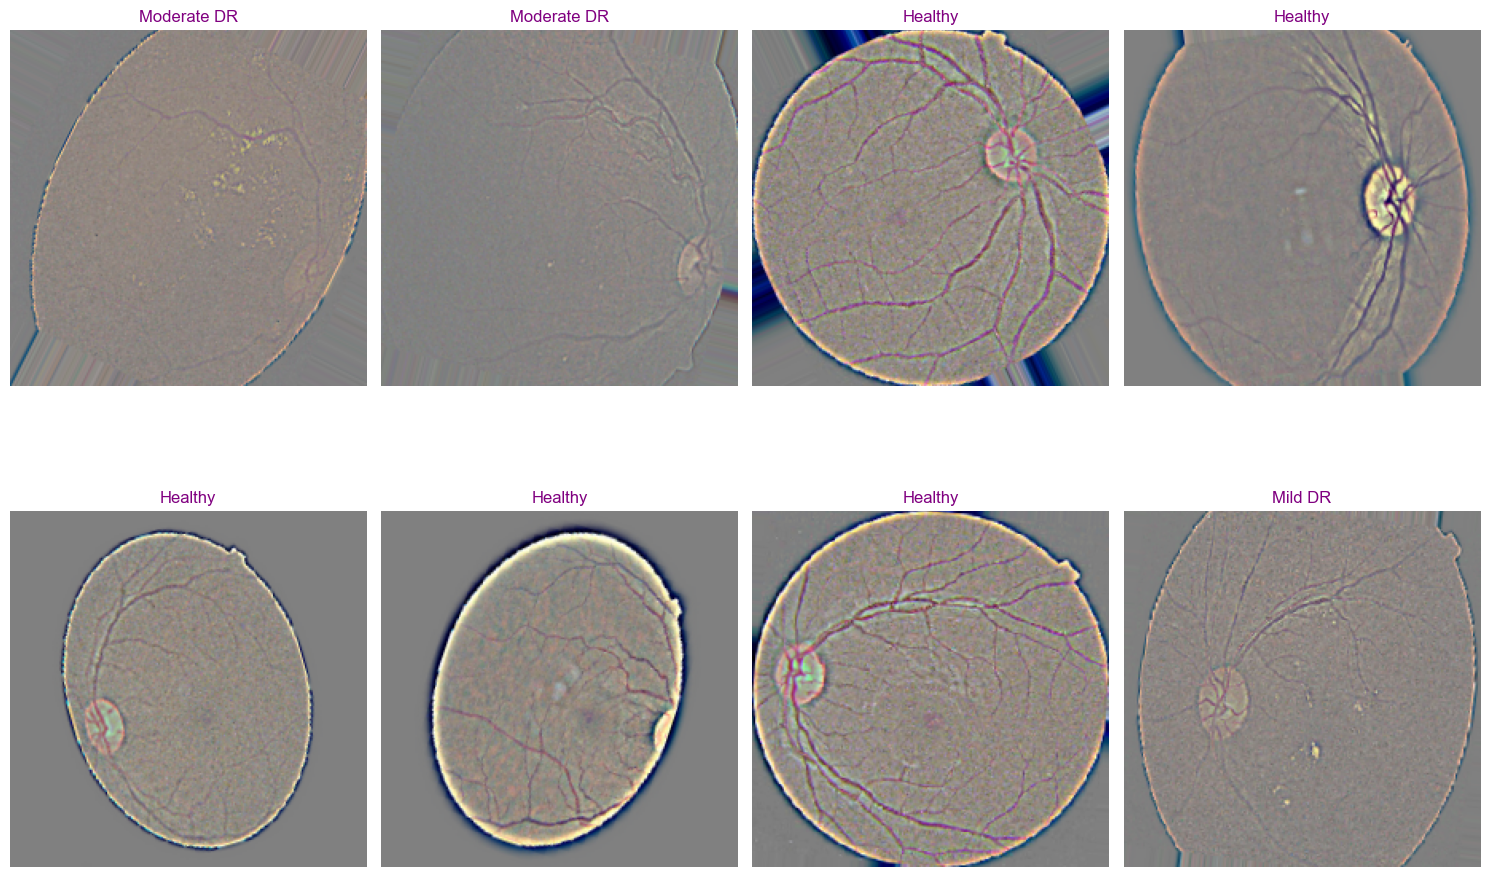

In [11]:
# Define labels and their indices as a dict
L_index = Train.class_indices
L_index

# Store Labels in a list
Keys = list(L_index.keys())
Keys

#Get a sample batch
imgs, labels = next(Train)

# Visualization
plt.figure(figsize= (15, 15))

for i in range(8):
    plt.subplot(3, 4, i +1)
    im = imgs[i]/255
    plt.imshow(im)

    #Labelling
    index = np.argmax(labels[i])
    label = Keys[index]
    plt.title(label, color = 'purple')
    plt.axis('off')

plt.tight_layout()
plt.show()

# **Modelling**

# Creating a model using transfer learning

In [12]:
# Define number of classes
n_classes = len(list(Train.class_indices.keys()))
img_shape = (img_size[0], img_size[1], 3)
EPOCHS = 50
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


# **Residual Network (ResNet)**

In [13]:
import os
import ssl
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Fix SSL issue
os.environ['PYTHONHTTPSVERIFY'] = '0'
ssl._create_default_https_context = ssl._create_unverified_context

# Model checkpoint to save the best model
checkpoint_resnet = ModelCheckpoint(
    "resnet_model.h5",
    monitor="val_accuracy",
    save_best_only=True,
    mode="max"
)

# Load the ResNet50 model
base_model_resnet = ResNet50(include_top=False, weights="imagenet", input_shape=img_shape, pooling='max')

# Build the model
model_resnet = Sequential([
    base_model_resnet,
    Dropout(0.3),
    Flatten(),
    Dense(512, activation='elu'),
    Dense(256, activation='elu'),
    Dense(128, activation='elu'),
    Dense(n_classes, activation='softmax')
])

In [14]:
# Compile the model
model_resnet.compile(
    optimizer=Adamax(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [15]:
model_resnet.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 2048)           │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,801,669 (94.61 MB)

 Trainable params: 24,748,549 (94.41 MB)

 Non-trainable params: 53,120 (207.50 KB)

# Training ResNet

In [16]:
np.random.seed(42)
history_resnet = model_resnet.fit(
    x=Train,
    epochs=EPOCHS,
    verbose=1,
    validation_data=Valid,
    callbacks=[early_stopping, checkpoint_resnet]  # Save the best model
)

Epoch 1/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.4997 - loss: 2.6834

110/110 ━━━━━━━━━━━━━━━━━━━━ 373s 3s/step - accuracy: 0.5001 - loss: 2.6777 - val_accuracy: 0.4400 - val_loss: 1.7053
Epoch 2/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5777 - loss: 1.4076

110/110 ━━━━━━━━━━━━━━━━━━━━ 338s 3s/step - accuracy: 0.5777 - loss: 1.4075 - val_accuracy: 0.6800 - val_loss: 0.9903
Epoch 3/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6473 - loss: 1.1107

110/110 ━━━━━━━━━━━━━━━━━━━━ 323s 3s/step - accuracy: 0.6471 - loss: 1.1110 - val_accuracy: 0.7127 - val_loss: 0.8822
Epoch 4/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 330s 3s/step - accuracy: 0.6570 - loss: 1.0210 - val_accuracy: 0.7018 - val_loss: 0.8532
Epoch 5/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 336s 3s/step - accuracy: 0.6760 - loss: 0.9186 - val_accuracy: 0.6582 - val_loss: 0.8993
Epoch 6/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7158 - loss: 0.7522

110/110 ━━━━━━━━━━━━━━━━━━━━ 334s 3s/step - accuracy: 0.7156 - loss: 0.7526 - val_accuracy: 0.7527 - val_loss: 0.7132
Epoch 7/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 332s 3s/step - accuracy: 0.7083 - loss: 0.8012 - val_accuracy: 0.7236 - val_loss: 0.7545
Epoch 8/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 334s 3s/step - accuracy: 0.7180 - loss: 0.7717 - val_accuracy: 0.7018 - val_loss: 0.7240
Epoch 9/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7428 - loss: 0.6863

110/110 ━━━━━━━━━━━━━━━━━━━━ 340s 3s/step - accuracy: 0.7428 - loss: 0.6865 - val_accuracy: 0.7564 - val_loss: 0.6539
Epoch 10/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 322s 3s/step - accuracy: 0.7243 - loss: 0.7002 - val_accuracy: 0.7491 - val_loss: 0.6931
Epoch 11/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 308s 3s/step - accuracy: 0.7648 - loss: 0.6588 - val_accuracy: 0.7309 - val_loss: 0.7018
Epoch 12/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 316s 3s/step - accuracy: 0.7725 - loss: 0.6070 - val_accuracy: 0.7200 - val_loss: 0.7596
Epoch 13/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 330s 3s/step - accuracy: 0.7859 - loss: 0.5976 - val_accuracy: 0.7564 - val_loss: 0.8379
Epoch 14/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 335s 3s/step - accuracy: 0.8020 - loss: 0.5167 - val_accuracy: 0.7491 - val_loss: 0.7655


In [17]:
# Save training history
tr_acc_resnet = history_resnet.history['accuracy']
tr_loss_resnet = history_resnet.history['loss']
v_acc_resnet = history_resnet.history['val_accuracy']
v_loss_resnet = history_resnet.history['val_loss']

# Get the best accuracy and loss
index_acc_resnet = np.argmax(v_acc_resnet)
high_Vacc_resnet = v_acc_resnet[index_acc_resnet]
index_loss_resnet = np.argmin(v_loss_resnet)
low_Vloss_resnet = v_loss_resnet[index_loss_resnet]
Epochs_resnet = list(range(1, len(tr_acc_resnet) + 1))

best_acc_resnet = f'Best epoch = {str(index_acc_resnet + 1)}'
best_loss_resnet = f'Best epoch = {str(index_loss_resnet + 1)}'

# Evaluation of ResNet

In [ ]:
# Plot accuracy and loss
plt.figure(figsize=(16, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs_resnet, tr_acc_resnet, "g", label="Train Accuracy")
plt.plot(Epochs_resnet, v_acc_resnet, "r", label="Validation Accuracy")
plt.scatter(index_acc_resnet + 1, high_Vacc_resnet, s=150, color='purple', label=best_acc_resnet)
plt.title("ResNet50 Accuracy: Train vs Validation")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs_resnet, tr_loss_resnet, "g", label="Train Loss")
plt.plot(Epochs_resnet, v_loss_resnet, "r", label="Validation Loss")
plt.scatter(index_loss_resnet + 1, low_Vloss_resnet, s=150, color='purple', label=best_loss_resnet)
plt.title("ResNet50 Loss: Train vs Validation")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


# Defining Variables for ResNet

In [19]:
# Load the best saved model
model_resnet = load_model("resnet_model.h5")

In [20]:
# Evaluate the ResNet50 model
train_scores_resnet = model_resnet.evaluate(Train, verbose=1)
test_scores_resnet = model_resnet.evaluate(Test, verbose=1)

# Print scores for ResNet50 model
print('ResNet50 Model Scores:')
print('Train Accuracy:', train_scores_resnet[1])
print('Train Loss:', train_scores_resnet[0])
print('Test Accuracy:', test_scores_resnet[1])
print('Test Loss:', test_scores_resnet[0])

110/110 ━━━━━━━━━━━━━━━━━━━━ 65s 580ms/step - accuracy: 0.7890 - loss: 0.5520
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 563ms/step - accuracy: 0.8413 - loss: 0.4512
ResNet50 Model Scores:
Train Accuracy: 0.796818196773529
Train Loss: 0.5338822603225708
Test Accuracy: 0.8136363625526428
Test Loss: 0.5061582922935486


# AdamW for optimizing the algorithm further

In [ ]:
import os
import ssl
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adamax, AdamW
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Ensure secure SSL
os.environ['PYTHONHTTPSVERIFY'] = '0'
ssl._create_default_https_context = ssl._create_unverified_context

# Set hyperparameters
EPOCHS = 50
n_classes = 10  # Update this based on your dataset
img_shape = (224, 224, 3)

# Load ResNet50 base model
base_model_resnet = ResNet50(include_top=False, weights="imagenet", input_shape=img_shape, pooling='max')

# Build the ResNet50 model
model_resnet = Sequential([
    base_model_resnet,
    Dropout(0.3),
    Flatten(),
    Dense(512, activation='elu'),
    Dense(256, activation='elu'),
    Dense(128, activation='elu'),
    Dense(n_classes, activation='softmax')
])

# Compile with Adamax
model_resnet.compile(
    optimizer=Adamax(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model_resnet.summary()

# Train the model
history_resnet = model_resnet.fit(
    x=Train,
    epochs=EPOCHS,
    verbose=1,
    validation_data=Valid,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
)

# Save the model
model_resnet.save('resnet_adamax_model.h5')

# Fine-tune with AdamW
optimizer_adamw = AdamW(learning_rate=1e-5, weight_decay=1e-4)

model_resnet.compile(
    optimizer=optimizer_adamw,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5, 
    patience=5, 
    min_lr=1e-7, 
    verbose=1
)

# Train with AdamW
history_resnet_adamw = model_resnet.fit(
    x=Train,
    epochs=EPOCHS,
    verbose=1,
    validation_data=Valid,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True), lr_scheduler]
)

# Save the fine-tuned model
model_resnet.save('resnet_adamw_model.h5')

# Evaluate the model
train_scores_resnet_adamw = model_resnet.evaluate(Train, verbose=1)
test_scores_resnet_adamw = model_resnet.evaluate(Test, verbose=1)

# Print scores
print('Optimized ResNet50 Model with AdamW Scores:')
print('Train Accuracy:', train_scores_resnet_adamw[1])
print('Train Loss:', train_scores_resnet_adamw[0])
print('Test Accuracy:', test_scores_resnet_adamw[1])
print('Test Loss:', test_scores_resnet_adamw[0])

# Plot accuracy and loss
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(history_resnet_adamw.history['accuracy'], label='Train Accuracy')
plt.plot(history_resnet_adamw.history['val_accuracy'], label='Validation Accuracy')
plt.title('Optimized ResNet50 Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_resnet_adamw.history['loss'], label='Train Loss')
plt.plot(history_resnet_adamw.history['val_loss'], label='Validation Loss')
plt.title('Optimized ResNet50 Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


# **Densenet169**

In [ ]:
np.random.seed(42)
base_model_densenet = DenseNet169(include_top=False, weights="imagenet", input_shape=img_shape, pooling='max')
model_densenet = Sequential([
    base_model_densenet,
    Dropout(0.3),
    Flatten(),
    Dense(512, activation='elu'),
    Dense(256, activation='elu'),
    Dense(128, activation='elu'),
    Dense(n_classes, activation='softmax')
])

In [ ]:
np.random.seed(42)
model_densenet.compile(
    Adamax(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['acc']
)

In [ ]:
model_densenet.summary()

# Training DenseNet

In [ ]:
np.random.seed(42)

history_densenet = model_densenet.fit(
    x=Train,
    epochs=EPOCHS,
    verbose=1,
    validation_data=Valid,
    callbacks=[early_stopping]
)

In [ ]:
# DenseNet169 history variables
tr_acc_densenet = history_densenet.history['acc']
tr_loss_densenet = history_densenet.history['loss']
v_acc_densenet = history_densenet.history['val_acc']
v_loss_densenet = history_densenet.history['val_loss']
index_acc_densenet = np.argmax(v_acc_densenet)
high_Vacc_densenet = v_acc_densenet[index_acc_densenet]
index_loss_densenet = np.argmin(v_loss_densenet)
low_Vloss_densenet = v_loss_densenet[index_loss_densenet]
Epochs_densenet = list(range(1, len(tr_acc_densenet) + 1))
best_acc_densenet = f'Best epoch ={str(index_acc_densenet + 1)}'
best_loss_densenet = f'Best epoch ={str(index_loss_densenet + 1)}'


# Evaluation of DenseNet

In [ ]:
# Plotting for DenseNet169 model
plt.figure(figsize=(16, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs_densenet, tr_acc_densenet, "g", label="Train Accuracy")
plt.plot(Epochs_densenet, v_acc_densenet, "r", label="Validation Accuracy")
plt.scatter(index_acc_densenet + 1, high_Vacc_densenet, s=150, color='purple', label=best_acc_densenet)
plt.title("DenseNet169 Accuracy: Train vs Validation")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs_densenet, tr_loss_densenet, "g", label="Train Loss")
plt.plot(Epochs_densenet, v_loss_densenet, "r", label="Validation Loss")
plt.scatter(index_loss_densenet + 1, low_Vloss_densenet, s=150, color='purple', label=best_loss_densenet)
plt.title("DenseNet169 Loss: Train vs Validation")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


# Defining variables for DenseNet

In [ ]:
# Evaluate DenseNet169 model
train_scores_densenet = model_densenet.evaluate(Train, verbose=1)
test_scores_densenet = model_densenet.evaluate(Test, verbose=1)

# Print scores for DenseNet169 model
print('DenseNet169 Model Scores:')
print('Train Accuracy:', train_scores_densenet[1])
print('Train Loss:', train_scores_densenet[0])
print('Test Accuracy:', test_scores_densenet[1])
print('Test Loss:', test_scores_densenet[0])


# AdamW for optimizing the algorithm further

In [ ]:
import os
import ssl
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import DenseNet169
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import AdamW

# Fixing SSL issue for downloading pre-trained weights
os.environ['PYTHONHTTPSVERIFY'] = '0'
ssl._create_default_https_context = ssl._create_unverified_context

# Load the DenseNet169 model
base_model_densenet = DenseNet169(include_top=False, weights="imagenet", input_shape=img_shape, pooling='max')

# Build the model
model_densenet = Sequential([
    base_model_densenet,
    Dropout(0.3),
    Flatten(),
    Dense(512, activation='elu'),
    Dense(256, activation='elu'),
    Dense(128, activation='elu'),
    Dense(n_classes, activation='softmax')
])

# Compile the model with AdamW optimizer
model_densenet.compile(
    optimizer=AdamW(learning_rate=0.0001, weight_decay=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model_densenet.summary()

# Train the model
np.random.seed(42)
history_densenet = model_densenet.fit(
    x=Train,
    epochs=EPOCHS,
    verbose=1,
    validation_data=Valid,
    callbacks=[early_stopping]
)

# Extract training history
tr_acc_densenet = history_densenet.history['accuracy']
tr_loss_densenet = history_densenet.history['loss']
v_acc_densenet = history_densenet.history['val_accuracy']
v_loss_densenet = history_densenet.history['val_loss']

# Find best accuracy and loss epochs
index_acc_densenet = np.argmax(v_acc_densenet)
high_Vacc_densenet = v_acc_densenet[index_acc_densenet]
index_loss_densenet = np.argmin(v_loss_densenet)
low_Vloss_densenet = v_loss_densenet[index_loss_densenet]
Epochs_densenet = list(range(1, len(tr_acc_densenet) + 1))

best_acc_densenet = f'Best epoch = {str(index_acc_densenet + 1)}'
best_loss_densenet = f'Best epoch = {str(index_loss_densenet + 1)}'

# Plot accuracy and loss
plt.figure(figsize=(16, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs_densenet, tr_acc_densenet, "g", label="Train Accuracy")
plt.plot(Epochs_densenet, v_acc_densenet, "r", label="Validation Accuracy")
plt.scatter(index_acc_densenet + 1, high_Vacc_densenet, s=150, color='purple', label=best_acc_densenet)
plt.title("DenseNet169 Accuracy: Train vs Validation")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs_densenet, tr_loss_densenet, "g", label="Train Loss")
plt.plot(Epochs_densenet, v_loss_densenet, "r", label="Validation Loss")
plt.scatter(index_loss_densenet + 1, low_Vloss_densenet, s=150, color='purple', label=best_loss_densenet)
plt.title("DenseNet169 Loss: Train vs Validation")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluate the model
train_scores_densenet = model_densenet.evaluate(Train, verbose=1)
test_scores_densenet = model_densenet.evaluate(Test, verbose=1)

# Print final scores
print('Optimized DenseNet169 Model with AdamW Scores:')
print('Train Accuracy:', train_scores_densenet[1])
print('Train Loss:', train_scores_densenet[0])
print('Test Accuracy:', test_scores_densenet[1])
print('Test Loss:', test_scores_densenet[0])

# Let me know if you want me to tweak anything or add more analysis! 🚀


# **EfficientNet**

In [ ]:
# EfficientNetB3 model
np.random.seed(42)
checkpoint_path = '/content/drive/MyDrive/efficientnet_checkpoint.h5'

base_model_efficientnet = EfficientNetB3(include_top=False, weights="imagenet", input_shape=img_shape, pooling='max')
model_efficientnet = Sequential([
    base_model_efficientnet,
    Dropout(0.3),
    Flatten(),
    Dense(512, activation='elu'),
    Dense(256, activation='elu'),
    Dense(128, activation='elu'),
    Dense(n_classes, activation='softmax')
])


In [ ]:
np.random.seed(42)
model_efficientnet.compile(
    Adamax(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['acc']
)


In [ ]:
np.random.seed(42)
checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

In [ ]:
model_efficientnet.summary()

In [ ]:
# Plot and display architecture for EfficientNetB3 model
from PIL import Image

# Plot and display architecture for EfficientNetB3 model
plot_model(model_efficientnet, to_file='efficientnet_model.png', show_shapes=True, show_layer_names=True)
Image.open('efficientnet_model.png')



# Training EfficientNet

In [ ]:
np.random.seed(42)
history_efficientnet = model_efficientnet.fit(
    x=Train,
    epochs=EPOCHS,
    verbose=1,
    validation_data=Valid,
    validation_steps=None,
    shuffle=False
)

In [ ]:
np.random.seed(42)
history_efficientnet = model_efficientnet.fit(
    x=Train,
    epochs=EPOCHS,
    verbose=1,
    validation_data=Valid,
    validation_steps=None,
    shuffle=False
)

In [ ]:
# EfficientNetB3 history variables
tr_acc_efficientnet = history_efficientnet.history['acc']
tr_loss_efficientnet = history_efficientnet.history['loss']
v_acc_efficientnet = history_efficientnet.history['val_acc']
v_loss_efficientnet = history_efficientnet.history['val_loss']
index_acc_efficientnet = np.argmax(v_acc_efficientnet)
high_Vacc_efficientnet = v_acc_efficientnet[index_acc_efficientnet]
index_loss_efficientnet = np.argmin(v_loss_efficientnet)
low_Vloss_efficientnet = v_loss_efficientnet[index_loss_efficientnet]
Epochs_efficientnet = list(range(1, len(tr_acc_efficientnet) + 1))
best_acc_efficientnet = f'Best epoch ={str(index_acc_efficientnet + 1)}'
best_loss_efficientnet = f'Best epoch ={str(index_loss_efficientnet + 1)}'


# Evaluation of EfficientNet

In [ ]:
# Plotting for EfficientNetB3 model
plt.figure(figsize=(16, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs_efficientnet, tr_acc_efficientnet, "g", label="Train Accuracy")
plt.plot(Epochs_efficientnet, v_acc_efficientnet, "r", label="Validation Accuracy")
plt.scatter(index_acc_efficientnet + 1, high_Vacc_efficientnet, s=150, color='purple', label=best_acc_efficientnet)
plt.title("EfficientNetB3 Accuracy: Train vs Validation")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs_efficientnet, tr_loss_efficientnet, "g", label="Train Loss")
plt.plot(Epochs_efficientnet, v_loss_efficientnet, "r", label="Validation Loss")
plt.scatter(index_loss_efficientnet + 1, low_Vloss_efficientnet, s=150, color='purple', label=best_loss_efficientnet)
plt.title("EfficientNetB3 Loss: Train vs Validation")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


# Defining Variables for EfficientNet

In [ ]:
# Evaluate EfficientNetB3 model
train_scores_efficientnet = model_efficientnet.evaluate(Train, verbose=1)
test_scores_efficientnet = model_efficientnet.evaluate(Test, verbose=1)

# Print scores for EfficientNetB3 model
print('EfficientNetB3 Model Scores:')
print('Train Accuracy:', train_scores_efficientnet[1])
print('Train Loss:', train_scores_efficientnet[0])
print('Test Accuracy:', test_scores_efficientnet[1])
print('Test Loss:', test_scores_efficientnet[0])


# AdamW for optimizing the algorithm further

In [ ]:
import os
import ssl
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import AdamW

# Fixing SSL issue for downloading pre-trained weights
os.environ['PYTHONHTTPSVERIFY'] = '0'
ssl._create_default_https_context = ssl._create_unverified_context

# Load the EfficientNetB3 model
base_model_effnet = EfficientNetB3(include_top=False, weights="imagenet", input_shape=img_shape, pooling='max')

# Build the model
model_effnet = Sequential([
    base_model_effnet,
    Dropout(0.3),
    Flatten(),
    Dense(512, activation='elu'),
    Dense(256, activation='elu'),
    Dense(128, activation='elu'),
    Dense(n_classes, activation='softmax')
])

# Compile the model with AdamW optimizer
model_effnet.compile(
    optimizer=AdamW(learning_rate=0.0001, weight_decay=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model_effnet.summary()

# Train the model
np.random.seed(42)
history_effnet = model_effnet.fit(
    x=Train,
    epochs=EPOCHS,
    verbose=1,
    validation_data=Valid,
    callbacks=[early_stopping]
)

# Extract training history
tr_acc_effnet = history_effnet.history['accuracy']
tr_loss_effnet = history_effnet.history['loss']
v_acc_effnet = history_effnet.history['val_accuracy']
v_loss_effnet = history_effnet.history['val_loss']

# Find best accuracy and loss epochs
index_acc_effnet = np.argmax(v_acc_effnet)
high_Vacc_effnet = v_acc_effnet[index_acc_effnet]
index_loss_effnet = np.argmin(v_loss_effnet)
low_Vloss_effnet = v_loss_effnet[index_loss_effnet]
Epochs_effnet = list(range(1, len(tr_acc_effnet) + 1))

best_acc_effnet = f'Best epoch = {str(index_acc_effnet + 1)}'
best_loss_effnet = f'Best epoch = {str(index_loss_effnet + 1)}'

# Plot accuracy and loss
plt.figure(figsize=(16, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs_effnet, tr_acc_effnet, "g", label="Train Accuracy")
plt.plot(Epochs_effnet, v_acc_effnet, "r", label="Validation Accuracy")
plt.scatter(index_acc_effnet + 1, high_Vacc_effnet, s=150, color='purple', label=best_acc_effnet)
plt.title("EfficientNetB3 Accuracy: Train vs Validation")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs_effnet, tr_loss_effnet, "g", label="Train Loss")
plt.plot(Epochs_effnet, v_loss_effnet, "r", label="Validation Loss")
plt.scatter(index_loss_effnet + 1, low_Vloss_effnet, s=150, color='purple', label=best_loss_effnet)
plt.title("EfficientNetB3 Loss: Train vs Validation")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluate the model
train_scores_effnet = model_effnet.evaluate(Train, verbose=1)
test_scores_effnet = model_effnet.evaluate(Test, verbose=1)

# Print final scores
print('Optimized EfficientNetB3 Model with AdamW Scores:')
print('Train Accuracy:', train_scores_effnet[1])
print('Train Loss:', train_scores_effnet[0])
print('Test Accuracy:', test_scores_effnet[1])
print('Test Loss:', test_scores_effnet[0])

# **Selecting the best model**

In [ ]:
# Evaluate ResNet50 model on test set
test_acc_resnet = model_resnet.evaluate(Test)[1]

# Evaluate DenseNet169 model on test set

test_acc_densenet = model_densenet.evaluate(Test)[1]

# Evaluate EfficientNetB3 model on test set

test_acc_efficientnet = model_efficientnet.evaluate(Test)[1]

# Compare validation accuracies
best_val_accuracy = max(test_acc_resnet, test_acc_densenet, test_acc_efficientnet)

# Compare test accuracies
if best_val_accuracy == test_acc_resnet:
    best_model_name = "ResNet50"
    best_test_accuracy = test_acc_resnet
elif best_val_accuracy == test_acc_densenet:
    best_model_name = "DenseNet169"
    best_test_accuracy = test_acc_densenet
else:
    best_model_name = "EfficientNetB3"
    best_test_accuracy = test_acc_efficientnet

# Print results
print("Accuracies:")
print("ResNet50:", test_acc_resnet)
print("DenseNet169:", test_acc_densenet)
print("EfficientNetB3:", test_acc_efficientnet)
print("\nBest Model Based on Validation Accuracy:", best_model_name)
print("Test Accuracy of Best Model:", best_test_accuracy)


# **Predictions**

In [ ]:
import numpy as np

models = {
    model_resnet: "ResNet50",
    model_densenet: "DenseNet169",
    model_efficientnet: "EfficientNetB3"
}

for model, model_name in models.items():  # iterate over keys and values
    print(f"Predictions for Model {model_name}:")

    # Perform predictions
    predictions = model.predict_generator(Test)

    # Get the predicted labels
    y_pred = np.argmax(predictions, axis=1)

    # Print predictions and corresponding labels
    print("Predictions:")
    print(predictions)
    print("Predicted Labels:")
    print(y_pred)
    print()


In [ ]:
from sklearn.metrics import confusion_matrix
import itertools

# Function to plot confusion matrix
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Greens):
    plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "red")
    plt.tight_layout()
    plt.xlabel('Predictions')
    plt.ylabel('Real Values')
    plt.show()




In [ ]:
classes = list(Test.class_indices.keys())

# Confusion Matrix for ResNet

In [ ]:
# Get predictions for ResNet50 model
y_pred_resnet = model_resnet.predict(Test)

# Calculate confusion matrix for ResNet50
cm_resnet = confusion_matrix(Test.classes, np.argmax(y_pred_resnet, axis=1))

# Plot confusion matrix for ResNet50
plot_confusion_matrix(cm_resnet, classes, title='Confusion Matrix - ResNet50')


# Confusion Matrix for DenseNet

In [ ]:
# Get predictions for DenseNet169 model
y_pred_densenet = model_densenet.predict(Test)

# Calculate confusion matrix for DenseNet169
cm_densenet = confusion_matrix(Test.classes, np.argmax(y_pred_densenet, axis=1))

# Plot confusion matrix for DenseNet169
plot_confusion_matrix(cm_densenet, classes, title='Confusion Matrix - DenseNet169')


# Confusion Matrix for EfficientNet

In [ ]:
# Get predictions for EfficientNetB3 model
y_pred_efficientnet = model_efficientnet.predict(Test)

# Calculate confusion matrix for EfficientNetB3
cm_efficientnet = confusion_matrix(Test.classes, np.argmax(y_pred_efficientnet, axis=1))

# Plot confusion matrix for EfficientNetB3
plot_confusion_matrix(cm_efficientnet, classes, title='Confusion Matrix - EfficientNetB3')


# Classification Report

In [ ]:
from sklearn.metrics import classification_report

# Generate classification reports for each model
report_resnet = classification_report(Test.classes, np.argmax(y_pred_resnet, axis=1), target_names=classes)
report_densenet = classification_report(Test.classes, np.argmax(y_pred_densenet, axis=1), target_names=classes)
report_efficientnet = classification_report(Test.classes, np.argmax(y_pred_efficientnet, axis=1), target_names=classes)

# Print classification reports
print("Classification Report - ResNet50:\n", report_resnet)
print("\nClassification Report - DenseNet169:\n", report_densenet)
print("\nClassification Report - EfficientNetB3:\n", report_efficientnet)

